In [2]:
x=RR['x'].gen()
x.parent()

Univariate Polynomial Ring in x over Real Field with 53 bits of precision

In [3]:
gexp=lambda p, offset: sum([x**(p*n+offset)/factorial(p*n+offset) for n in range(40)])

In [4]:
expargs = dict(xmin=-6, xmax=9, ymin=-10, ymax=600)
bndargs = dict(xmin=-16, xmax=16, ymin=-6, ymax=6)
tbndargs = dict(xmin=-1, xmax=32, ymin=-.5, ymax=.5)
tbndargs = dict(xmin=-32, xmax=32, ymin=-.5, ymax=.5)

tbndSargs = dict(xmin=-30, xmax=30, ymin=-2.5, ymax=2.5)

In [5]:
P=plot([
    gexp(1, 0), 
    *[gexp(2, offset) for offset in range(2)],
    *[gexp(3, offset) for offset in range(3)],
    *[gexp(4, offset) for offset in range(4)],
    *[gexp(5, offset) for offset in range(5)],
    *[gexp(6, offset) for offset in range(6)],
    *[gexp(7, offset) for offset in range(7)],
], **expargs)

P.save('multi-sub-exponential.png')

In [6]:
RR((25**80)/factorial(80))

9.56033193518996e-8

In [7]:
def hypscale(ff, factor):
    def _f(x):
        return ff(x)*exp(factor*x)
    
    return _f

def hypEscale(ff, factor):
    def _f(x):
        return ff(x)/cosh(-1*factor*x)
    
    return _f

def enum_diff_ring(G_d_i, delta):
    d = len(G_d_i)
    assert 0 < delta < d
    for _i in range(d):
        _j = _i + delta
        if _j >= d:
            i, j = _i, _j - d
        else:
            i, j = _i, _j
        yield G_d_i[i] - G_d_i[j]

In [8]:
WIDTH_EPS = 0.00001
ZERO_EPS = 0.0000001

def bisect(ff, xmin, xmax):
    b1 = ff(xmin)
    b2 = ff(xmax)

    if abs(b1) < ZERO_EPS:
        return xmin
    if abs(b2) < ZERO_EPS:
        return xmax

    if b1 * b2 > 0:
        raise RuntimeError(f'bisection failed {xmin} < {xmax}')

    while True and xmax-xmin > WIDTH_EPS:
        xmid = xmin + (xmax-xmin)/2
        
        #print(f'bisection progress {xmin} < {xmid} < {xmax}')
        
        bmid = ff(xmid)
        
        if abs(bmid) < ZERO_EPS:
            return xmid
        
        if xmax-xmid <= WIDTH_EPS:
            return xmid
        
        if bmid * b1 > 0:
            xmin = xmid
        elif bmid * b2 > 0:
            xmax = xmid
        else:
            raise RuntimeError(f'bisection failed {xmin} < {xmid} < {xmax}')

def find_zero_train(ff, xmax=50):
    flast = ff(1.)
    xlast = 1.
    
    if abs(flast) < ZERO_EPS:
        yield xlast

        flast = ff(1.25)
        xlast = 1.25
        
    for n in range(2, int(xmax)):
        fnext = ff(RR(n))
        xnext = RR(n)
        
        if abs(fnext) < ZERO_EPS:
            yield xnext
            
            fnext = ff(n+0.25)
            xnext = n+0.25
        elif flast * fnext < 0.:
            yield bisect(ff, xlast, xnext)

        #print(f'f({n})={round(fnext, 3)}')
            
        flast = fnext
        xlast = xnext


In [42]:
import numpy

def _find_scale_factor(f, fac_bound, xmax=50):
    zeros = list(find_zero_train(f, xmax=xmax))
    if len(zeros) > 8:
        right_zeros = zeros[-7:]
    else:
        right_zeros = zeros[2:]
    
    periods = [x2-x1 for x1, x2 in zip(right_zeros[:-1], right_zeros[1:])]
    if numpy.std(periods) >= .01:
        raise RuntimeError('period length varies too much: ', numpy.std(periods))
    elif len(periods) < 5:
        raise RuntimeError('not enough zeros to find period:  '+str(zeros))
        
    period = numpy.mean(periods)
    #print(period*2)
    
    lmap = lambda func, ll: list(map(func, ll))
    
    # expect oscillation so that alternating mid-zero points are mins and maxes
    xmins = [z-period/2 for z in right_zeros[::2]]
    xmaxs = [z-period/2 for z in right_zeros[1::2]]
    ymins = lmap(f, xmins)
    ymaxs = lmap(f, xmaxs)
    if numpy.mean(ymins) > 0:
        xmins, xmaxs = xmaxs, xmins
        ymins, ymaxs = ymaxs, ymins
    if numpy.mean(ymaxs) <= 0 or numpy.mean(ymins) >= 0:
        raise RuntimeError('not detecting oscillation')

    smin = fac_bound[0]
    smax = fac_bound[1]
    for _ in range(15):
        peaks = lmap(hypscale(f, smax), xmaxs)
        if peaks[0] / peaks[-1] > 1:
            raise RuntimeError('scale factor {smax} not bounding')
        peaks = lmap(hypscale(f, smin), xmaxs)
        if peaks[0] / peaks[-1] < 1:
            raise RuntimeError('scale factor {smin} not bounding')
        
        smid = fac_bound[2](smin, smax)
        peaks = lmap(hypscale(f, smid), xmaxs)
        if peaks[0] / peaks[-1] > 1:
            smin = smid
        elif peaks[0] / peaks[-1] < 1:
            smax = smid
        else:
            # must have gotten perfectly to scaled
            break

    factor = fac_bound[2](smin, smax)
    amps = lmap(hypscale(f, factor), xmaxs)
    return factor, period*2, [numpy.mean(amps), numpy.std(amps)]

def find_scale_factor(f, xmax=50):
    return _find_scale_factor(f, (-10., -.1, lambda s1, s2: -sqrt(s1*s2)), xmax)

/tmp/ipykernel_2752630/1996478547.py:39: RuntimeWarning: invalid value encountered in double_scalars
  if peaks[Integer(0)] / peaks[-Integer(1)] < Integer(1):


-0.965814672460608
24.27686055501302


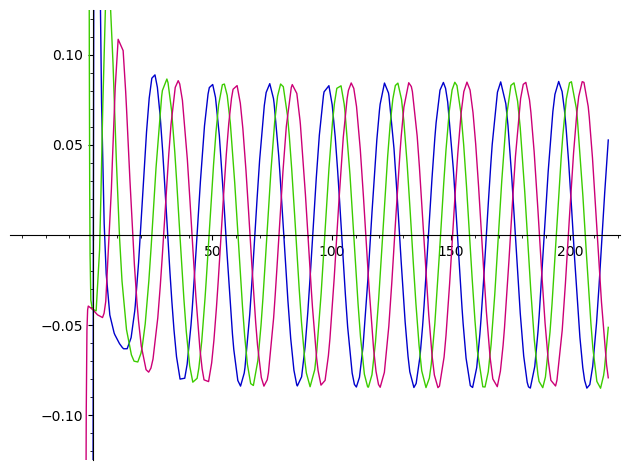

In [59]:
d=24

Gd = [gexp(d, j) for j in range(d)]

if d == 2:
    scale = 0
elif d == 3:
    scale = .5
elif d == 4:
    scale = 0
else:
    Gdd = list(enum_diff_ring(Gd, 1))

    scale, period, amplitude = find_scale_factor(Gdd[0], xmax=d*7)

    print(scale)
    print(period)

#show(plot(Gd, **expargs))
#show(plot([(lambda x, H=G: (exp(x)/d-H(x))) for G in Gd], **tbndSargs))
#show(plot([(lambda x, H=G: (exp(x)/d-H(x))*exp(scale*x)) for G in Gd], **tbndSargs))

modtbnd = tbndSargs.copy()
modtbnd['ymin'] = -.12
modtbnd['ymax'] = .12
modtbnd['xmax'] =d*9

show(plot([(lambda x, H=G: (H(x)-exp(x)/d)*exp(scale*x)) for G in [Gd[1], Gd[6], Gd[11]]], **modtbnd))

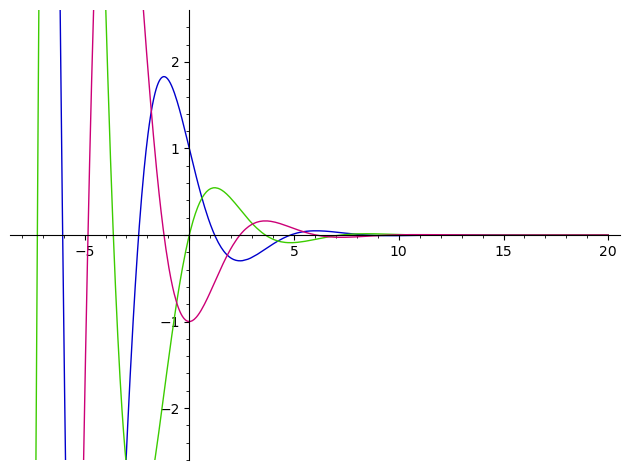

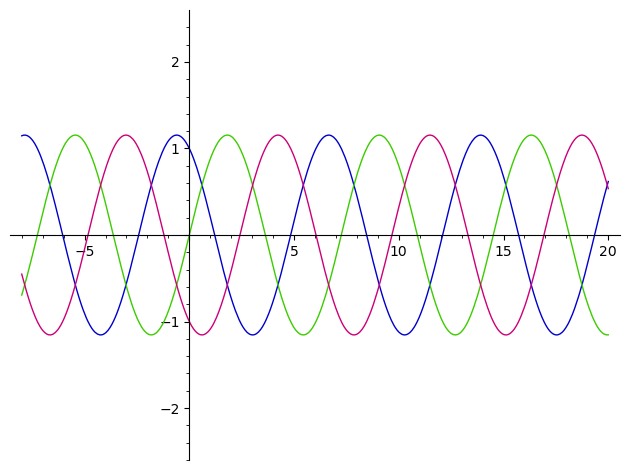

In [46]:
G3 = [gexp(3, j) for j in range(3)]
G3d = list(enum_diff_ring(G3, 1))
G3h=[hypscale(f, 0.500) for f in G3d]

tbndargs = dict(xmin=-8, xmax=20, ymin=-2.5, ymax=2.5)

P3_unscaled = plot(G3d, **tbndargs)
P3_unscaled.save('g3_family_unscaled.png')
show(P3_unscaled)
P3_scaled = plot(G3h, **tbndargs)
P3_scaled.save('g3_family_scaled.png')
P3_scaled

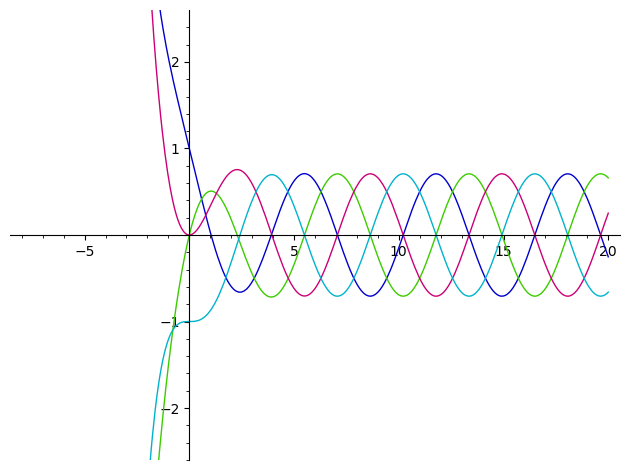

In [9]:
G4 = [gexp(4, j) for j in range(4)]
G4d = list(enum_diff_ring(G4, 1))
#G3h=[hypscale(f, .5) for f in G3d]

#show(plot(G3d, **tbndargs))
P4_unscaled=plot(G4d, **tbndargs)
P4_unscaled.save('g4_family_unscaled.png')
P4_unscaled

In [10]:
zeros=list(find_zero_train(G4d[0]))
zeros

G4d[0](zeros[5]+(zeros[6]-zeros[5])/2)

0.707106787839038

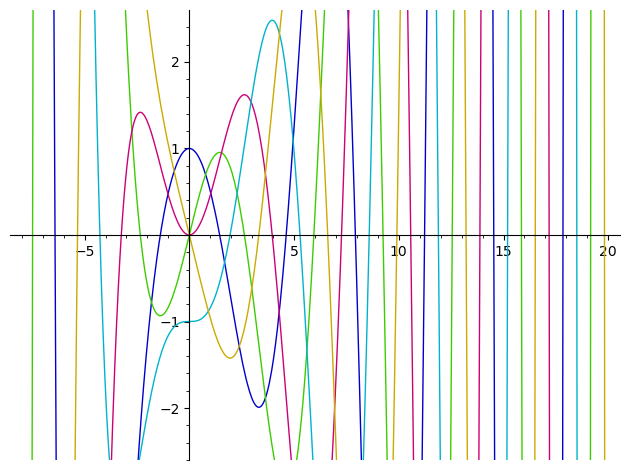

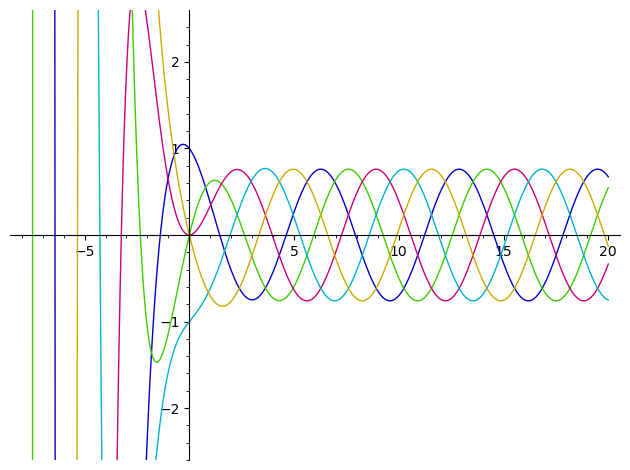

In [14]:
d=5

Gd = [gexp(d, j) for j in range(d)]
Gdd = list(enum_diff_ring(Gd, 2))
Gdh=[hypscale(f, -.309) for f in Gdd]

show(plot(Gdd, **tbndargs))
plot(Gdh, **tbndargs)

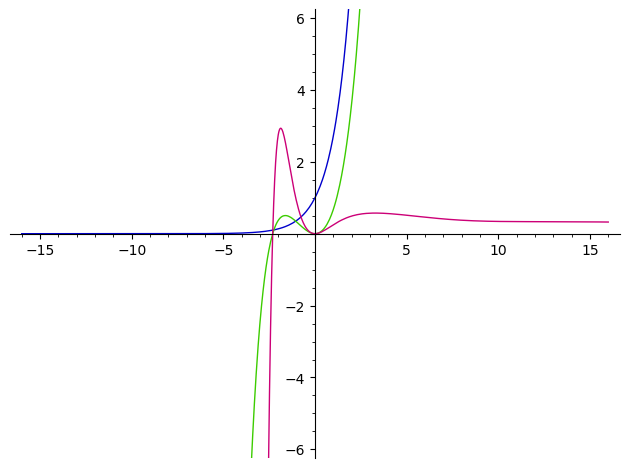

In [12]:
Gp = sum([x**p/factorial(p) for _, p in zip(range(40), Primes())])

#for i, p in zip(range(40), Primes()):
#    print(p)

plot([exp, Gp, lambda x: Gp(x)/exp(x)], **bndargs)

In [38]:

def print_diff_table(xlist):
    layer = list(xlist)
    for level in range(3):
        print((' '*5*level)+'  '.join(f'{x:8.3f}' for x in layer))
        
        if len(layer) < 2:
            break
        
        layer = [y-x for x, y in zip(layer[:-1], layer[1:])]

-0.623403573041308
8.0367919921875


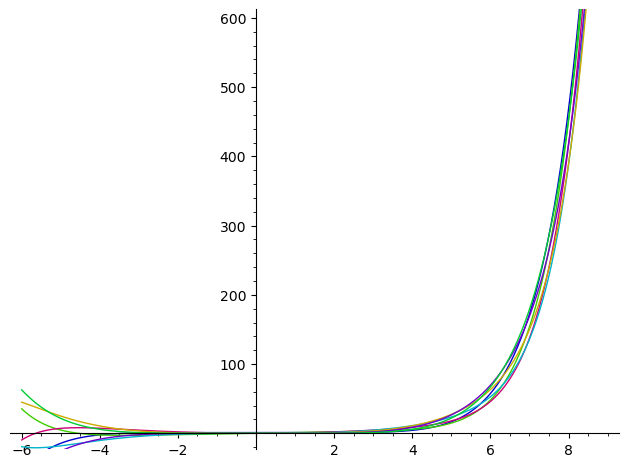

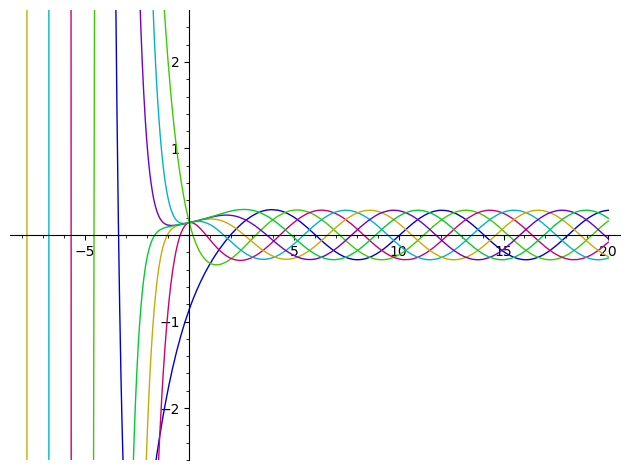

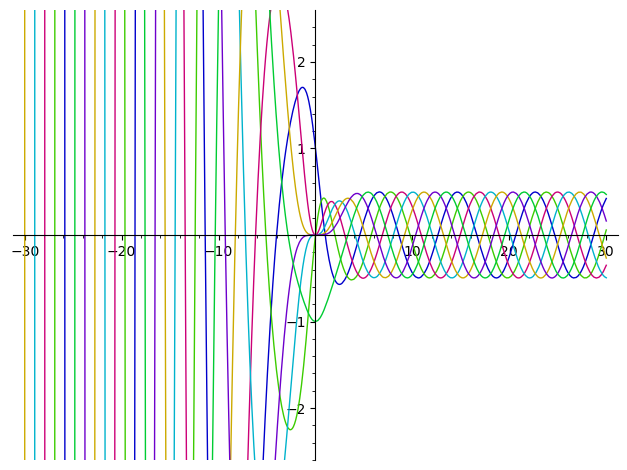

In [34]:
d=7

Gd = [gexp(d, j) for j in range(d)]
Gdd = list(enum_diff_ring(Gd, 1))

scale, period, amplitude = find_scale_factor(Gdd[0])

print(scale)
print(period)

Gdh=[hypEscale(f, scale) for f in Gdd]

show(plot(Gd, **expargs))
show(plot([(lambda x, H=G: (exp(x)/d-H(x))*exp(scale*x)) for G in Gd], **tbndargs))
plot(Gdh, **tbndSargs)

In [61]:
1/.70716

1.41410713275638

In [51]:
lines = []

d=3
Gd = [gexp(d, j) for j in range(d)]
Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

scales = []
periods = []
amplitudes = {} # bucketed by delta
for i in range(d-1):
    for j in range(i+1, d):
        diff = lambda x: exp(x)*(Gd[i](x)-Gd[j](x))

        try:
            scale, period, amplitude = find_scale_factor_3(diff, xmax=35.+d*3.)
            delta = j-i if j-i <= d/2 else i+d-j

            scales.append(scale)
            periods.append(period)
            assert amplitude[1] <= 0.01
            amplitudes[delta] = amplitudes.get(delta, [])+[amplitude[0]]
        except RuntimeError as e:
            print(d, i, j, str(e))

amps = [f'{numpy.mean(amplitudes[delta]):6.3f}' for delta in sorted(amplitudes.keys())]
print(d, amps)

lines.append((d, scale, period, ''.join(amps)))


#lines.append((3, 0.5, 7.256, '??'))


d=4
Gd = [gexp(d, j) for j in range(d)]
Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

scales = []
periods = []
amplitudes = {} # bucketed by delta
for i in range(d-1):
    for j in range(i+1, d):
        diff = Gd[i]-Gd[j]

        try:
            scale, period, amplitude = find_scale_factor_4(diff, xmax=35.+d*3.)
            delta = j-i if j-i <= d/2 else i+d-j

            scales.append(scale)
            periods.append(period)
            assert amplitude[1] <= 0.01
            amplitudes[delta] = amplitudes.get(delta, [])+[amplitude[0]]
        except RuntimeError as e:
            print(d, i, j, str(e))

amps = [f'{numpy.mean(amplitudes[delta]):6.3f}' for delta in sorted(amplitudes.keys())]
print(d, amps)

lines.append((d, scale, period, ''.join(amps)))


#lines.append((4, '--', r'$2\pi$', '1.000'))

for d in range(5, 13):
    Gd = [gexp(d, j) for j in range(d)]
    Gdd = [Gd[i]-Gd[j] for i in range(d-1) for j in range(i+1, d)]

    scales = []
    periods = []
    amplitudes = {} # bucketed by delta
    for i in range(d-1):
        for j in range(i+1, d):
            diff = Gd[i]-Gd[j]

            try:
                scale, period, amplitude = find_scale_factor(diff, xmax=35.+d*3.)
                delta = j-i if j-i <= d/2 else i+d-j

                scales.append(scale)
                periods.append(period)
                assert amplitude[1] <= 0.01
                amplitudes[delta] = amplitudes.get(delta, [])+[amplitude[0]]
            except RuntimeError as e:
                print(d, i, j, str(e))
                
    #scale, period = find_scale_factor(Gdd[0]-Gdd[1])

    #assert numpy.std(scales) <= 0.001
    #assert numpy.std(period) <= 0.001
    #for delta in sorted(amplitudes.keys()):
    #    assert numpy.std(amplitudes[delta]) <= 0.001
        
    amps = [f'{numpy.mean(amplitudes[delta]):6.3f}' for delta in sorted(amplitudes.keys())]
    print(d, amps)
        
    lines.append((d, scale, period, ''.join(amps)))
    
line2 = []
for line in lines:
    if line[0] == 4:
        line2.append(line)
    else:
        line2.append((line[0], f'{line[1]:8.3f}', f'{line[2]:8.3f}', line[3]))
    
print(table(line2, header_row=['d', 'scale', 'period', 'amplitudes'], align='right', frame=True))

3 0 1 not enough zeros to find period:  [1.20920562744141, 4.83679962158203, 8.46439361572266, 12.0920028686523, 15.7195968627930, 19.3476562500000, 23.1250000000000, 25.7460937500000, 27.2187500000000, 30.5000000000000, 34.7031250000000, 35.4957199096680, 36.1250000000000, 38.2500000000000, 40.0000000000000]
3 0 2 not enough zeros to find period:  [2.41840362548828, 6.04599761962891, 9.67359161376953, 13.3012008666992, 16.9287948608398, 20.5576171875000, 26.2500000000000, 29.0000000000000, 29.9351406097412, 31.0000000000000, 32.0000000000000, 33.0000000000000, 34.0000000000000, 36.0000000000000, 37.0000000000000, 37.9947528839111, 41.0000000000000, 41.7880954742432, 43.0000000000000]
3 1 2 not enough zeros to find period:  [3.62760162353516, 7.25519561767578, 10.8827896118164, 14.5103988647461, 18.1380920410156, 21.7421875000000, 25.7500000000000, 28.4425048828125, 29.4765625000000, 34.1249389648438, 35.8437500000000, 36.6418457031250, 39.0000000000000, 39.3613281250000, 41.8750000000